# Missing values and cleaning

## Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince\[Month/Year\] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since\[Year/Week\] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
%matplotlib inline

In [3]:
train_dtypes = {'Store':'object','Sales':'int','Customers':'int',
               'Open':'object', 'Promo':'object', 'StateHoliday':'object', 'SchoolHoliday':'object'}

In [4]:
df_train = pd.read_csv('/home/timbo/Repos/kaggle/rossmann/datasets/train.csv', delimiter=',', dtype=train_dtypes,
                      parse_dates=['DayOfWeek','Date'])

In [5]:
test_dtypes = {'Store':'object','Id':'object','Customers':'int',
               'Open':'object', 'Promo':'object', 'StateHoliday':'object', 'SchoolHoliday':'object'}

In [6]:
df_test = pd.read_csv('/home/timbo/Repos/kaggle/rossmann/datasets/test.csv', ',', dtype=train_dtypes,
                      parse_dates=['DayOfWeek','Date'])

In [7]:
stores_dtypes = {'Store':'object','StoreType':'object','Assortment':'object',
               'CompetitionDistance':'float', 'Promo2':'object', 'PromoInterval':'object','CompetitionOpenSinceYear':'object'}

In [8]:
df_stores = pd.read_csv('/home/timbo/Repos/kaggle/rossmann/datasets/store.csv', delimiter=',',
                       parse_dates=['CompetitionOpenSinceMonth',
                                   'Promo2SinceWeek', 'Promo2SinceYear'], dtype=stores_dtypes)

In [9]:
df_train_store_combined = pd.merge(df_train, df_stores, on='Store')

In [10]:
# concate 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' where 'CompetitionOpenSinceYear' is not null
df_train_store_combined.loc[df_train_store_combined['CompetitionOpenSinceYear'].notnull(), 'CompetitionOpenSince'] = \
df_train_store_combined['CompetitionOpenSinceYear'].astype(str).str.split('-').apply(lambda x:x[0]) + '-' + df_train_store_combined['CompetitionOpenSinceMonth'].astype(str)

In [11]:
df_train_store_combined.loc[df_train_store_combined['Promo2SinceYear'].notnull(), 'Promo2Since'] = \
df_train_store_combined['Promo2SinceYear'].astype(str).str.split('-').apply(lambda x:x[0]) + '-' + df_train_store_combined['Promo2SinceWeek'].astype(str)

In [12]:
df_train_store_combined['Promo2Since'] = pd.to_datetime(df_train_store_combined['Promo2Since'] + '0',format='%Y-%W%w')

In [13]:
df_train_store_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
Store                        1017209 non-null object
DayOfWeek                    1017209 non-null object
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null object
Promo                        1017209 non-null object
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null object
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null object
CompetitionOpenSinceYear     693861 non-null object
Promo2                       1017209 non-null object
Promo2SinceWeek              509178 non-null object
Promo2SinceYear              509178

In [21]:
df_train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [22]:
df_test.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [24]:
df_stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [25]:
df_train_store_combined.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
CompetitionOpenSince         323348
Promo2Since                  508031
dtype: int64

impute with mode or drop

In [74]:
df = df_train_store_combined.groupby('Date')['Open'].count().reset_index()
df['No data'] = 1115 - df['Open']
df[df['No data'] != 0]

,Date,Open,No data
0,2013-01-01,1114,1
546,2014-07-01,935,180
547,2014-07-02,935,180
548,2014-07-03,935,180
549,2014-07-04,935,180
...,...,...,...
725,2014-12-27,935,180
726,2014-12-28,935,180
727,2014-12-29,935,180
728,2014-12-30,935,180


Not full data for 185 days

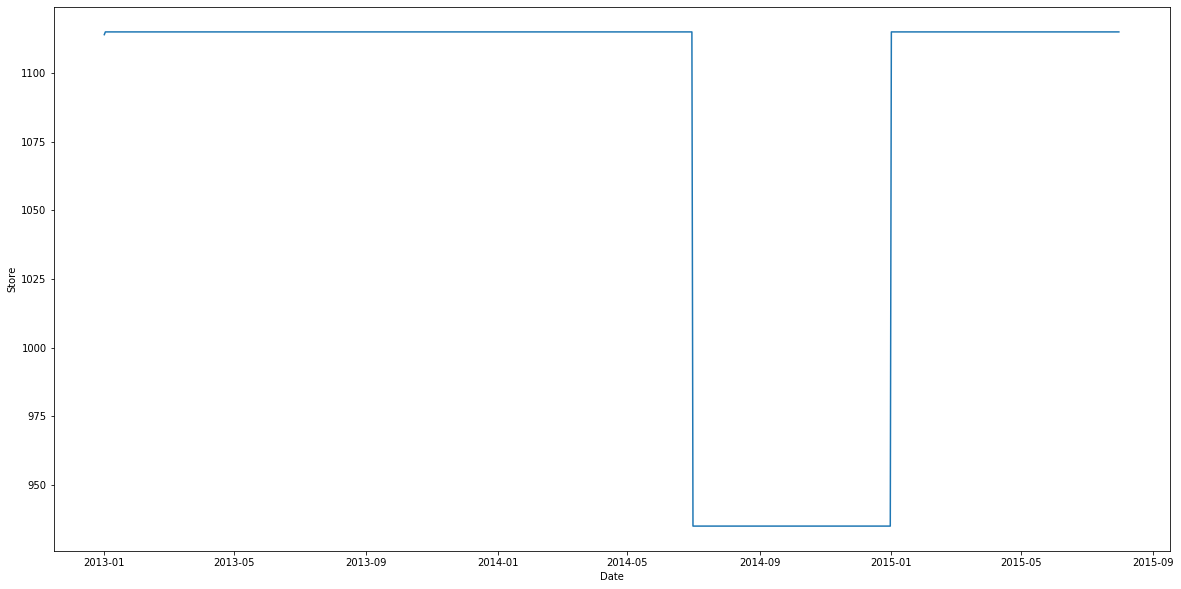

In [72]:
plt.figure(figsize=(20,10))
sns.lineplot(x='Date',y='Store',data=df_train_store_combined.groupby('Date')['Store'].count().reset_index())
plt.show()

Which stores per date?

In [142]:
stores = set(df_train_store_combined['Store'].astype('int').sort_values().unique().tolist())
dates = df_train_store_combined['Date'].sort_values().unique()
missing_stores_per_date = collections.OrderedDict()
for date in dates:
    df = df_train_store_combined[df_train_store_combined['Date'] == date]
    stores_date = set(df['Store'].astype('int').unique())
    if len(stores - stores_date) != 0:
        missing_stores_per_date[date] = stores - stores_date

In [157]:
missing_stores_per_date

OrderedDict([(numpy.datetime64('2013-01-01T00:00:00.000000000'), {988}),
             (numpy.datetime64('2014-07-01T00:00:00.000000000'),
              {13,
               20,
               22,
               32,
               36,
               41,
               46,
               51,
               52,
               58,
               72,
               76,
               81,
               89,
               99,
               100,
               108,
               113,
               115,
               127,
               129,
               132,
               136,
               137,
               139,
               144,
               145,
               149,
               155,
               159,
               164,
               165,
               172,
               174,
               181,
               183,
               186,
               190,
               191,
               192,
               204,
               215,
               218,
               23